In [1]:
# spacy will be used for lemmatization and stop words removal it's better than nltk
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Downloading the small model 
!python -m spacy download en_core_web_sm

/home/verpen/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2022-09-15 04:12:42.121074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 04:12:42.121107: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-15 04:13:35.955326: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-15 04:13:35.955466: I tensorflow/stream_executor/cuda/cuda_d

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
import seaborn as sn
from spacy.lang.en.stop_words import STOP_WORDS
import emoji
import contractions
import string
import nltk 
import emot
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time
from sklearn.model_selection import GridSearchCV

In [4]:
pd.set_option('max_colwidth', 450)

# Loading data

In [5]:
# We used sentiment140 dataset because it has different domains, 
# and US Airline Twitter because it has a greate number of tweets 
# with emojis and emoticons that used extensively in social media
sent140_data = pd.read_csv('/home/verpen/Downloads/Datasets/Sentiment140.csv', encoding = "ISO-8859-1")
us_airline_data = pd.read_csv('/home/verpen/Downloads/Datasets/US_Airline_Tweets.csv')

# Data analysis


### Analysis of Sentiment140 dataset

In [6]:
sent140_data

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


In [7]:
sent140_data.columns

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

In [8]:
# Rename columns
sent140_data = sent140_data.rename(columns={'0': 'tweet_sentiment', 
                   "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D": "text"})

# Keep tweet_sentiment and text drop the rest columns
sent140_data = sent140_data[['tweet_sentiment', 'text']]
sent140_data.sample(5)

,tweet_sentiment,text
1181765,4,"@Dannymcfly daaaaaany, good luck in tv show i see *-* my english is very very bad, sorry sL"
1548271,4,@andrea_r so it would seem. Good if you wanted your own multi-user video site (also known as a news agency)
1365496,4,"Choral Sex. You like that play on words, don't you?"
695074,0,"@smueller94, do you have a guitar?:O damn why does everybody has a guitar and play guitar? i want it 2"
421374,0,waiting waiting waiting waiting I hate waiting


In [9]:
# Positive tweets = 4, 
# Negative tweets = 0
sent140_data['tweet_sentiment'].value_counts()

4    800000
0    799999
Name: tweet_sentiment, dtype: int64

In [10]:
# Choose a random subset from the dataset with equal number of 
# positive and negative tweets
subset = 10000
pos_subset = sent140_data[sent140_data['tweet_sentiment'] == 4].sample(subset)
neg_subset = sent140_data[sent140_data['tweet_sentiment'] == 0].sample(subset)

sent140_data = pd.concat([pos_subset, neg_subset])

In [11]:
# Change positive tweet sentiment index from 4 to 1
sent140_data['tweet_sentiment'] = sent140_data['tweet_sentiment'].apply(lambda x: 1 if x == 4 else 0)

In [12]:
# Check if null value exists
sent140_data.isnull().value_counts()

tweet_sentiment  text 
False            False    20000
dtype: int64

In [13]:
sent140_data.sample(5)

,tweet_sentiment,text
1170988,1,"@TheAnimalHouse Conrgats!!! They're picking up on the 16th of June, and I'm about to get baking, so you'll have some freshies"
915119,1,Won a gps at post prom
925866,1,@DuongSheahan are you tweeting in church...I love that your so cool
400248,0,Mcdonalds for breakfast. Gotta get ready for work...
347838,0,"Animal control just picked up the lost dog. Tried not to cry, but it was no use"


### Analysis of US Airline Tweets dataset


In [14]:
us_airline_data.sample(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11397,568141720556322816,negative,1.0,Late Flight,1.0,US Airways,NaN,tayyp_,NaN,0,"@USAirways I been sitting on this plane for 40 minutes, and they are saying another 15 minutes something about paper work. This sucks !!","[35.210373, -80.9538682]",2015-02-18 12:15:16 -0800,Made in China,Central Time (US & Canada)
7747,569278644943757312,positive,1.0,NaN,NaN,Delta,NaN,sbgblee,NaN,0,@JetBlue thanks for your prompt response. I know you put safety first. Unfortunately will hit freezing rain/sleet on ride home.,NaN,2015-02-21 15:33:00 -0800,NaN,NaN
4913,569655614432915456,negative,1.0,Late Flight,1.0,Southwest,NaN,attra_versiamo,NaN,0,@SouthwestAir Seriously? FOUR DELAYS? Only takes 42 minutes to get to Vegas from @flyLAXairport &amp; I have a connecting flight. #ridiculous,NaN,2015-02-22 16:30:56 -0800,NaN,NaN


In [15]:
# Remove tweets with sentiment_confidence less than 0.7
us_airline_data = us_airline_data[us_airline_data['airline_sentiment_confidence'] >= 0.7]

# We only interested in the airline_sentiment column and the text column
us_airline_data = us_airline_data[['airline_sentiment', 'text']]

# Rename airline_sentiment column into tweet_sentiment
us_airline_data = us_airline_data.rename(columns={'airline_sentiment': 'tweet_sentiment'})

us_airline_data.sample(3)

,tweet_sentiment,text
532,neutral,@united and what am I suppose to do with that number?
10586,negative,@USAirways - been on hold with reservations for over 30 min already! #worstairline
6024,neutral,@SouthwestAir adds new direct flights from #Columbus to Oakland &amp; Boston starting August 2015 #cmh #oak #bos


In [16]:
us_airline_data = us_airline_data

In [17]:
# Remove neutral tweets
us_airline_data = us_airline_data[(us_airline_data['tweet_sentiment'] == 'positive') 
                                  | (us_airline_data['tweet_sentiment'] == 'negative')]


In [18]:
us_airline_data.sample(5)

,tweet_sentiment,text
11084,negative,.@USAirways I guess from now on I should take my chances &amp; keep the $50 for the courtesy free because it seems cabin is always full.
12659,negative,@AmericanAir We tried with multiple people. I already sat on the phone for an hour and a half and got nowhere.
11593,negative,@USAirways my sister was supposed to leave at 10 am to go back to AL. She's only getting to NC now. Are you kidding me #NeverflyUSairways 👿
756,negative,@united airlines is the absolute worst. They have no idea what they are doing. #neveragain #UnitedAirlines
95,negative,"@VirginAmerica Is it me, or is your website down? BTW, your new website isn't a great user experience. Time for another redesign."


In [19]:
# Label categorical values in the airline_sentiment column with: posisitve = 1 and negative = 0
us_airline_data['tweet_sentiment'] = us_airline_data['tweet_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [20]:
us_airline_data.sample(5)

,tweet_sentiment,text
7748,1,@JetBlue ok!!! That's super helpful. Thank you. I'll reach out if I have any other questions.
12577,0,.@AmericanAir how about connecting me with a customer service rep? I'd rather speak to a person than a computer. Thanks!
10587,0,@USAirways now the 3rd issue with the plane is a fuel leak. They will let us know soon what they decide. #getmeoffthisplane #ineedabeer
37,1,"@VirginAmerica @freddieawards Done and done! Best airline around, hands down!"
30,0,"@VirginAmerica hi! I just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during Flight Booking Problems 😢"


In [21]:
us_airline_data['tweet_sentiment'].value_counts()

0    7552
1    1582
Name: tweet_sentiment, dtype: int64

In [22]:
# Because the dataset is imbalanced, we will take all positive tweets
# and 1600 negative tweets randomely selected
pos_subset = us_airline_data[us_airline_data['tweet_sentiment'] == 1]
neg_subset = us_airline_data[us_airline_data['tweet_sentiment'] == 0].sample(1600)
us_airline_data = pd.concat([pos_subset, neg_subset])
us_airline_data

,tweet_sentiment,text
9,1,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."
11,1,@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D
12,1,@VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven't even gone on my 1st trip yet! ;p
14,1,@VirginAmerica Thanks!
16,1,@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo
...,...,...
8303,0,@JetBlue My bag is missing from 1099 landed over 6 hours ago. Help!
10113,0,@USAirways I got rebooked at 3am after they woke me up just tried to call twice and got hung up on. Worst customer service.
7331,0,@JetBlue I did. They have no idea where it is.
918,0,@united Agent in LAS letting 20 customers know they can't help them rebook delayed flight to DEN #unfriendlyskies http://t.co/QuzVmK2rTR


In [23]:
# Concat sent140_data with us_airline_data
modified_data = pd.concat([sent140_data, us_airline_data])
modified_data

,tweet_sentiment,text
1046222,1,@Flowsionet hey! thanks for the followfriday!
1198739,1,@elvisduran I realllllly need the miracle worker! I'm dying to see @taylorswift13 at MSG and the tickets are sold out =( Please help me!
1424409,1,@souljaboytellem of course! Its a lil somethin positive to look forward to in a negative world! Keep 'em commin
927046,1,@DavidArchie Thank you so much for spending time with us! Take Care!
973859,1,@MilliaAtSeaRAWR d00d how was BMTH?
...,...,...
8303,0,@JetBlue My bag is missing from 1099 landed over 6 hours ago. Help!
10113,0,@USAirways I got rebooked at 3am after they woke me up just tried to call twice and got hung up on. Worst customer service.
7331,0,@JetBlue I did. They have no idea where it is.
918,0,@united Agent in LAS letting 20 customers know they can't help them rebook delayed flight to DEN #unfriendlyskies http://t.co/QuzVmK2rTR


In [24]:
# Shuffle data
modified_data = modified_data.sample(frac=1)
modified_data = modified_data.reset_index(drop=True)
modified_data

,tweet_sentiment,text
0,0,"@Gen22 Yeah, stupid sleep got in the way! I wasnt on twitter that much last night."
1,0,@AmericanAir is profiting in the billions and throwing crap at the people who put them there. American is a hurting brand
2,0,I have to go find a real darkroom....I have an actual film camera and the autowinder snapped a roll last week. Major uncool.
3,1,@ducban agree. new #iconeden of @mintran &amp; Frexy is awesome
4,1,@AmericanAir thanks for the show! 👍
...,...,...
23177,0,Sore throat
23178,0,Broke a finger I think
23179,1,@PDInventive well i think i've forgotten how to write to be honest...a bad skill to lose....maybe i'll practice over the weekend
23180,0,My pics won't upload


In [25]:
modified_data['tweet_sentiment'].value_counts()

0    11600
1    11582
Name: tweet_sentiment, dtype: int64

# Data Preprocessing

In [26]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "1st" : "first", 
    "2nd" : "second", 
    "3rd" : "third",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "canx" : "cancel",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dnt" : "don't",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "emerg" : "emergency",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "haha" : "laugh", 
    "hahaha" : "laugh", 
    "hehe" : "laugh", 
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrs" : "hour",
    "hrh" : "his royal highness",    
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pls" : "please",
    "plz" : "please",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rite" : "right",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sry" : "sorry",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thank" : "thank",
    "thanks" : "thank",
    "thks" : "thank",
    "tho" : "though",
    "thx" : "thank",
    "tia" : "thanks in advance",
    "til" : "until",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "us" : "united states",
    "usa" : "united states",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "ya" : "you",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

# This abbreviation list is by @nmaguette from Kaggle

In [27]:
# Load spacy model
# This model will be used for NER and lemmatization
nlp = spacy.load('en_core_web_sm')

In [28]:
def expand_abbr(tweet):
    """ This function takes an abbreviated string
        and returns the expanded version with whitespace 
        replaced by underscore """
    
    expanded_abbr = ''
    expanded_tweet = ''
    for word in tweet:
        expanded_abbr = word
        if word in abbreviations: 
            expanded_abbr = abbreviations[word]
            expanded_abbr = expanded_abbr.replace(' ', '_')          
        
        expanded_tweet = expanded_tweet + expanded_abbr + " "
    
    return expanded_tweet

In [29]:
def remove_ner(tweet): 
    """ This function removes Named Entity Recognition """
    
    doc = nlp(tweet)
    for word in doc.ents:
        tweet = tweet.replace(word.text, '')    
    return tweet

In [30]:
emot_obj = emot.core.emot()

In [31]:
emoj_time = 0
emot_time = 0
def emoj_emot_to_text(tweet):
    """ This function converts emojis and emoticons to corresponding text """
    global emoj_time
    global emot_time
    
    # Emoticons  
    start = time.perf_counter() #time  
    emoticons_list = emot_obj.emoticons(tweet)['mean']
    for emoticon in emoticons_list: 
        emoticon = emoticon.replace(', ', ' ')
        emoticon = emoticon.replace(' ', '_')
        tweet = tweet + emoticon + " "       
    end = time.perf_counter() #time
    emot_time = emot_time + (end - start)
    
    
    # Emojis
    start = time.perf_counter()
    tweet = emoji.demojize(tweet) 
    tweet = re.sub(':', '', tweet)
    end = time.perf_counter()
    emoj_time = emoj_time + (end - start)
    return tweet

In [32]:
stop_words = list(STOP_WORDS)

# Exclude from stop words list the following negative words
stop_words.remove('not')
stop_words.remove('never')
stop_words.remove('none')
stop_words.remove('noone')
stop_words.remove('neither')

In [33]:
def remove_trivial_words(tweet):  
    """ This function Removes stopwords and words with length of one character or two """
    
    temp = ""
    for word in tweet.split():
        if  word not in stop_words:
            if len(word) != 1 and len(word) != 2:
                temp += word + " "
    return temp

In [34]:
negative_words = ['not', 'never', 'none', 'neither', 'no one']

def negation_handling(tweet):
    """ This function uses a static window of size 1 to handle negation.
        If a negative word detected this function will append the word
        (not) with the next word, with underscore connecting the two words.
        For example the sentence: I can't swim ==> I can not_swim """
    
    negated_str = ""
    # Use spacy tokenizer
    doc = nlp(tweet)
    #for word in doc:
    for word in tweet.split():
        #word = str(word)
        if word in negative_words:
            negated_str = negated_str + 'not' + "_"         
        else:
            negated_str = negated_str + word + " "
        
    return negated_str

In [35]:
regex_time = 0
expand_time = 0
lemma_time = 0
emoj_emot_time = 0
trivial_time = 0
negation_time = 0

def preprocess_tweets(tweet): 
    global regex_time
    global expand_time
    global lemma_time
    global emoj_emot_time
    global trivial_time
    global negation_time
    
    start = time.perf_counter()
    #     Preprocess tweets
    tweet = tweet.lower() # Convert to lower case
    tweet = contractions.fix(tweet) # Remove contractions
    
    #     Remove unecessary characters using regex
    tweet = re.sub('\S+@\S+.\S+', '', tweet) # Remove emails
    tweet = re.sub('@[\S]+', '', tweet) # Remove mentions starting with @       
    tweet = re.sub('(http|https):\/\/[\S]*', '', tweet) # Remove links starting with http or https
    tweet = re.sub('#+\S*|\.+', '', tweet) # Remove Hashtags and dots
    tweet = re.sub(r'(.)\1{2,}', r'\1', tweet) # Remove characters repetition
    tweet = re.sub(r'&[\S]+;', '', tweet) # Remove html tags, such as &amp;
    
    end = time.perf_counter()
    regex_time = regex_time + (end - start)
    
    tweet = re.split('(\W+)', tweet)
    
    start = time.perf_counter()
    # Expand abbreviations
    tweet = expand_abbr(tweet)
    end = time.perf_counter()
    expand_time = expand_time + (end - start)
    
    # Remove Named Entity recognition
    #tweet = remove_ner(tweet)
    
    start = time.perf_counter()
    # Lemmatization using spacy lemmatizer
    concat_str = ""
    doc = nlp(tweet)
    for word in doc:
        concat_str += word.lemma_ + " "
    tweet = concat_str
    
    end = time.perf_counter()
    lemma_time = lemma_time + (end - start)
    
    start = time.perf_counter()
    # Emojis and Emoticons
    tweet = emoj_emot_to_text(tweet)
    end = time.perf_counter()
    emoj_emot_time = emoj_emot_time + (end - start)
    
    # Remove remaining punctuations
    tweet = re.sub('\W', ' ', tweet)    
    tweet = re.sub('\d', '', tweet)  # Remove Numbers  
    
    start = time.perf_counter()
    # Remove trivial words
    tweet = remove_trivial_words(tweet)
    end = time.perf_counter()
    trivial_time = trivial_time + (end - start)
    
    start = time.perf_counter()
    # Handle negations
    tweet = negation_handling(tweet)        
    end = time.perf_counter()
    negation_time = negation_time + (end - start)
    
    # Tokenization
    tweet = word_tokenize(tweet)

    return tweet #Return processed tweet as a list

In [36]:
preprocess_tweets("sooo tired. the thunderstorm kept me up all night. reaaaallllllllly")

['tired', 'thunderstorm', 'night', 'realy']

In [37]:
preprocess_tweets("ahhh can't wait for the MTV movie awards yeaaahhh! talkin to @BrittanyASnow on myspace. sry if i dnt reply rite away")

['not_wait',
 'mtv',
 'movie',
 'award',
 'yeah',
 'talkin',
 'myspace',
 'sorry',
 'not_reply',
 'right',
 'away']

In [38]:
re.sub(r'(.)\1{2,}', r'\1', "ahhhhhhh can't wait for the MTV movie awards yeaaaaaaaahhh! talkin to @BrittanyASnow on myspace. sry if i dnt reply rite away")

"ah can't wait for the MTV movie awards yeah! talkin to @BrittanyASnow on myspace. sry if i dnt reply rite away"

# Test time it take to finish processing

In [39]:
short_data = pd.concat([sent140_data, us_airline_data])
short_data = short_data.sample(frac=1)
short_data = short_data.reset_index(drop=True)
short_data

,tweet_sentiment,text
0,0,"@thepixiepop Unfortunately, I have big feet for a woman."
1,1,@Brandieee Sorry we left! :/ I'm not able to read your tweets from my phone so I didn't know y'all were going. Next time!
2,1,"@chokewho Thanks, as ever, for #followfriday props"
3,0,@MadsODG57 i was looking @ E news a minute ago...but couldn't get any sound from it!
4,0,@SouthwestAir make this delay go away. Maybe upgrade me and Kats seats. We are headed to Columbus.
...,...,...
23177,1,"aw, I'm tired.. and my dad is here. think I should go now. tweeted enough today. night night at all! I love you followers. xx"
23178,0,@united Slightly better. Crew spent a long time searching for better altitude. Would have helped to let pax in on why all the sharp drops.
23179,0,@united the best seats should be for paying customers and we should get to board first #badcustomerservice
23180,1,"I had a fun Saturday: Movies, dinner, malasadas and a walk around the neighborhood"


In [40]:
start = time.perf_counter()
short_data['Tokens'] = short_data['text'].apply(preprocess_tweets)
end = time.perf_counter()
total = (end - start)

In [41]:
short_data.sample(10)

,tweet_sentiment,text,Tokens
6181,1,Wireless Internet in my home!!! Best life ever!! http://twitpic.com/5fevi,"[wireless, internet, home, good, life]"
18628,0,@stefsull -- migraines are the worst. I used to get them when I was a teenager. They're no fun at all!,"[migraine, bad, use, teenager, fun]"
5444,1,@SouthwestAir thanks for the drink tickets hook up! Can't wait for my first international flight with you to NAS! #pumped,"[thank, drink, ticket, hook, not_wait, international, flight, nas]"
7509,0,is kinda sad. What's everyone else up to?,"[kind, sad]"
17305,0,@united 3 hour 45 min delay so far..... Would love to round to 4 hours to just go to bed!,"[hour, min, delay, far, love, round, hour, bed]"
20826,1,"@Lynne90 I mean Newcastle in Ireland, not England! Or is it in Northern Ireland? &amp; do- tell her LAURA LOVES HER AAF.","[mean, newcastle, ireland, not_england, northern, ireland, tell, laura, love, aaf]"
966,0,@USAirways - who do I call to use credit fm. prev. cxl tix that can't be rebooked online?Rep I called quoted me $1k higher than the website.,"[use, credit, prev, cxl, tix, not_rebooke, online, rep, quote, high, website]"
11151,1,It's my last day of school! And I am leaving early. I just have to go in tomorrow for 2 tests and I am done for the summerrrrr. !,"[day, school, leave, early, tomorrow, test, summer]"
13416,0,@darch4ever awwz that sucks!! i hope u get ur tickets and ur dad's car gets fixed!,"[awwz, suck, hope, ticket, dad, car, gets, fix]"
14408,0,last night it was way too warm under mums blanket. had to move all night long. annoying to all of us. and something bit me at my throat,"[night, way, warm, mum, blanket, night, long, annoying, united_state, bit, throat]"


In [42]:
print(f"""Regex time: {regex_time}
Expand time: {expand_time}
Lemma time: {lemma_time}
emoj_emot_time: {emoj_emot_time}\tEmoj time: {emoj_time}\tEmot time: {emot_time}
Trivial time: {trivial_time}
Negation time: {negation_time}
Total time: {total}""")

Regex time: 1.2379461210030058
Expand time: 0.2137049849916366
Lemma time: 171.03577308000786
emoj_emot_time: 1.2783779820197196	Emoj time: 0.896176806022595	Emot time: 0.33368154200388744
Trivial time: 1.420220405991131
Negation time: 111.68813847803176
Total time: 289.28208622600005


# End of test

In [43]:
# Preprocess each tweet (text column)
modified_data['Tokens'] = modified_data['text'].apply(preprocess_tweets)

In [44]:
modified_data.to_excel('/home/verpen/Downloads/Datasets/Sentiment140_Us_Airline.xlsx')
#modified_data = pd.read_csv('/home/verpen/Downloads/Datasets/Sentiment140_Modified_5000_tweets.csv')

In [45]:
modified_data

,tweet_sentiment,text,Tokens
0,0,"@Gen22 Yeah, stupid sleep got in the way! I wasnt on twitter that much last night.","[yeah, stupid, sleep, way, not_twitter, night]"
1,0,@AmericanAir is profiting in the billions and throwing crap at the people who put them there. American is a hurting brand,"[profit, billion, throw, crap, people, american, hurt, brand]"
2,0,I have to go find a real darkroom....I have an actual film camera and the autowinder snapped a roll last week. Major uncool.,"[find, real, darkroomi, actual, film, camera, autowinder, snap, roll, week, major, uncool]"
3,1,@ducban agree. new #iconeden of @mintran &amp; Frexy is awesome,"[agree, new, frexy, awesome]"
4,1,@AmericanAir thanks for the show! 👍,"[thank, thumbs_up]"
...,...,...,...
23177,0,Sore throat,"[sore, throat]"
23178,0,Broke a finger I think,"[break, finger, think]"
23179,1,@PDInventive well i think i've forgotten how to write to be honest...a bad skill to lose....maybe i'll practice over the weekend,"[think, forget, write, honesta, bad, skill, losemaybe, practice, weekend]"
23180,0,My pics won't upload,"[pic, not_upload]"


In [46]:
# Convert token lists to string 
def convert_list_str(tokens):
    return ' '.join(tokens)
modified_data['String_tokens'] = modified_data['Tokens'].apply(convert_list_str)

In [47]:
modified_data

,tweet_sentiment,text,Tokens,String_tokens
0,0,"@Gen22 Yeah, stupid sleep got in the way! I wasnt on twitter that much last night.","[yeah, stupid, sleep, way, not_twitter, night]",yeah stupid sleep way not_twitter night
1,0,@AmericanAir is profiting in the billions and throwing crap at the people who put them there. American is a hurting brand,"[profit, billion, throw, crap, people, american, hurt, brand]",profit billion throw crap people american hurt brand
2,0,I have to go find a real darkroom....I have an actual film camera and the autowinder snapped a roll last week. Major uncool.,"[find, real, darkroomi, actual, film, camera, autowinder, snap, roll, week, major, uncool]",find real darkroomi actual film camera autowinder snap roll week major uncool
3,1,@ducban agree. new #iconeden of @mintran &amp; Frexy is awesome,"[agree, new, frexy, awesome]",agree new frexy awesome
4,1,@AmericanAir thanks for the show! 👍,"[thank, thumbs_up]",thank thumbs_up
...,...,...,...,...
23177,0,Sore throat,"[sore, throat]",sore throat
23178,0,Broke a finger I think,"[break, finger, think]",break finger think
23179,1,@PDInventive well i think i've forgotten how to write to be honest...a bad skill to lose....maybe i'll practice over the weekend,"[think, forget, write, honesta, bad, skill, losemaybe, practice, weekend]",think forget write honesta bad skill losemaybe practice weekend
23180,0,My pics won't upload,"[pic, not_upload]",pic not_upload


# Analyze data after processing

In [48]:
# Count the number of tokens in the dataset after processing
num_unique_tokens = 0
num_of_total_tokens = 0
num_pos_tokens = 0
num_neg_tokens = 0
pos_tokens = []
neg_tokens = []
rows = modified_data.shape[0]

for i in range(rows):
    if modified_data['tweet_sentiment'][i] == 0:
        for token in modified_data['Tokens'][i]:
            neg_tokens.append(token)    
    else:
        for token in modified_data['Tokens'][i]:
            pos_tokens.append(token)     

num_pos_tokens = len(pos_tokens)
num_neg_tokens = len(neg_tokens)
num_of_total_tokens = num_pos_tokens + num_neg_tokens
num_unique_tokens = len(set(pos_tokens)) + len(set(neg_tokens))

print(f"""Number of tokens: {num_of_total_tokens}
Number of unique tokens: {num_unique_tokens}
Positive Tokens: {num_pos_tokens}
Negative Tokens: {num_neg_tokens}
Positive Unique Tokens: {len(set(pos_tokens))}
Negative Unique Tokens: {len(set(neg_tokens))}""")

Number of tokens: 131042
Number of unique tokens: 24050
Positive Tokens: 63511
Negative Tokens: 67531
Positive Unique Tokens: 12016
Negative Unique Tokens: 12034


In [49]:
# Calculate words occurances 
def occurances_of_words(dataframe, reverse=True):
    freq_words_dic = {}
    rows = dataframe.shape[0]
    
    for i in range(rows):
        for word in dataframe['Tokens'][i]:
            if word in freq_words_dic:
                freq = freq_words_dic[word]
                freq_words_dic[word] = freq + 1
            else:
                freq_words_dic[word] = 1
    return sorted(freq_words_dic.items(), key=lambda x: x[1], reverse=reverse)

In [50]:
# Calculate words occurances in negative tweets
neg_modified_data = modified_data[modified_data['tweet_sentiment'] == 0]
neg_modified_data = neg_modified_data.reset_index(drop=True)

neg_freq_words = occurances_of_words(neg_modified_data)
sorted(neg_freq_words, key=lambda x: x[1], reverse=True)[:20]

[('day', 670),
 ('miss', 631),
 ('flight', 612),
 ('work', 610),
 ('want', 577),
 ('like', 512),
 ('time', 499),
 ('today', 471),
 ('hour', 442),
 ('need', 417),
 ('bad', 388),
 ('feel', 382),
 ('think', 378),
 ('sad', 368),
 ('good', 359),
 ('home', 328),
 ('know', 308),
 ('come', 296),
 ('tomorrow', 294),
 ('try', 287)]

In [51]:
# Calculate words occurances in positive tweets
pos_modified_data = modified_data[modified_data['tweet_sentiment'] == 1]
pos_modified_data = pos_modified_data.reset_index(drop=True)

pos_freq_words = occurances_of_words(pos_modified_data)
sorted(pos_freq_words, key=lambda x: x[1], reverse=True)[:20]

[('thank', 1446),
 ('good', 1032),
 ('love', 815),
 ('day', 730),
 ('great', 533),
 ('like', 500),
 ('time', 459),
 ('work', 438),
 ('laugh', 428),
 ('today', 421),
 ('laughing_out_loud', 413),
 ('new', 373),
 ('know', 352),
 ('night', 341),
 ('think', 323),
 ('flight', 323),
 ('watch', 302),
 ('come', 301),
 ('hope', 296),
 ('happy', 292)]

In [52]:
def plot_ten_freq_words(freq_words_list, label, color):
    """ Plot a bar chart with the ten most frequent words """
    
    ten_freq_words = [f_item[0] for f_item in freq_words_list]
    occurances = [s_item[1] for s_item in freq_words_list]    
    
    # X ticks position
    x_pos = [x*2 for x in range(10)]

    plt.bar(x_pos, occurances, align='center', width=1.5, alpha=0.8, color=color, label=label)
    plt.xlabel('Most Frequent Words')
    plt.ylabel('Number of occurances')
    plt.legend()
    plt.xticks(x_pos, ten_freq_words, rotation='vertical')
    plt.show()

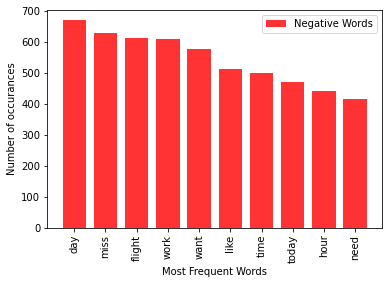

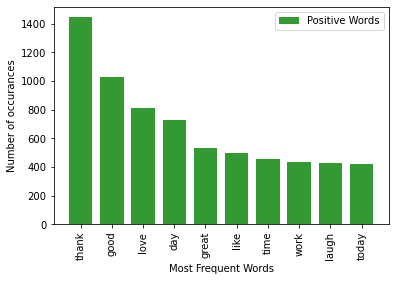

In [53]:
ten_neg_freq_words = neg_freq_words[:10]
ten_neg_freq_words
plot_ten_freq_words(ten_neg_freq_words, 'Negative Words', 'red')
ten_pos_freq_words = pos_freq_words[:10]
ten_pos_freq_words
plot_ten_freq_words(ten_pos_freq_words, 'Positive Words', 'green')

# Feature Extraction and Model Training

### Without fixing overlapping

In [193]:
X_train, y_test = train_test_split(modified_data, test_size=0.2)
print(f'Splitted data: \nTrain Dimensions: {X_train.shape}\nTest Dimensions: {y_test.shape}\n')

tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
tfidf.fit(X_train['String_tokens'])
trained_tfidf = tfidf.transform(X_train['String_tokens'])
test_tfidf = tfidf.transform(y_test['String_tokens'])
print(f'Fitted data: \nTrain Dimensions: {trained_tfidf.shape}\nTest Dimensions: {test_tfidf.shape}')

Splitted data: 
Train Dimensions: (9612, 4)
Test Dimensions: (2403, 4)

Fitted data: 
Train Dimensions: (9612, 20000)
Test Dimensions: (2403, 20000)


In [194]:
log_model = LogisticRegression()

In [195]:
score = cross_val_score(log_model, trained_tfidf, X_train['tweet_sentiment'], cv=10, scoring='accuracy')
print(f'Average accuracy: {score.mean()}')

Average accuracy: 0.8965880352456834


In [196]:
log_model.fit(trained_tfidf, X_train['tweet_sentiment'])

LogisticRegression()

In [197]:
log_model.score(test_tfidf, y_test['tweet_sentiment'])

0.8951310861423221

### Fixing Overlapping

In [ ]:
# Compare between words that exist in both pos and neg tweets
# by counting their occurances in both categories.
# If for example a word occured in pos tweets more than
# neg tweets, then store the word in a dictionary as a key,
# and the value will be 0, which is the encoding of neg category
top_words = 200
top_pos_word = pos_freq_words[:top_words]  # List of tuples
top_neg_word = neg_freq_words[:top_words]  # List of tuples
overlapped_word = {}

for i in range(top_words):
    for j in range(top_words):
        
        # Pos word equals neg word
        if top_pos_word[i][0] == top_neg_word[j][0]:
            print(f'Pos: {top_pos_word[i]}\tNeg: {top_neg_word[j]}')
            
            # Pos word occurances is greater than neg word
            if top_pos_word[i][1] > top_neg_word[j][1]:
                overlapped_word[top_neg_word[j][0]] = 0
            else:
                overlapped_word[top_pos_word[i][0]] = 1

In [60]:
# Store indexes of tweets with overlapping 
rows = modified_data.shape[0]
indexes = set()
for i in range(rows):
    for token in modified_data['Tokens'][i]:
        for word, sent in overlapped_word.items():
            if token ==  word and modified_data['tweet_sentiment'][i] == sent:
                indexes.add(i)    

In [61]:
# Remove tweets 
for i in indexes:
    modified_data = modified_data.drop(index=i)

In [62]:
modified_data = modified_data.reset_index(drop=True)
modified_data

,tweet_sentiment,text,Tokens,String_tokens
0,0,@AmericanAir is profiting in the billions and throwing crap at the people who put them there. American is a hurting brand,"[profit, billion, throw, crap, people, american, hurt, brand]",profit billion throw crap people american hurt brand
1,0,I have to go find a real darkroom....I have an actual film camera and the autowinder snapped a roll last week. Major uncool.,"[find, real, darkroomi, actual, film, camera, autowinder, snap, roll, week, major, uncool]",find real darkroomi actual film camera autowinder snap roll week major uncool
2,1,@ducban agree. new #iconeden of @mintran &amp; Frexy is awesome,"[agree, new, frexy, awesome]",agree new frexy awesome
3,1,@AmericanAir thanks for the show! 👍,"[thank, thumbs_up]",thank thumbs_up
4,1,@SazziBee yey! Might you come on a visit?! You can now follow Upnor and Rochester castles on Twitter,"[yey, come, visit, follow, upnor, rochester, castle, twitter]",yey come visit follow upnor rochester castle twitter
...,...,...,...,...
12010,0,:O i just lost 4 followers!,"[lose, follower]",lose follower
12011,1,"@csharpzealot have to ask the DPE Oz guys that one. As for the future, I'm hopeful but who knows how the world shapes up over nxt 2 yrs","[ask, dpe, guy, future, hopeful, know, world, shape, nxt]",ask dpe guy future hopeful know world shape nxt
12012,0,Sore throat,"[sore, throat]",sore throat
12013,0,Broke a finger I think,"[break, finger, think]",break finger think


In [63]:
modified_data['tweet_sentiment'].value_counts()

0    6102
1    5913
Name: tweet_sentiment, dtype: int64

In [64]:
# Calculate words occurances in negative tweets
neg_modified_data = modified_data[modified_data['tweet_sentiment'] == 0]
neg_modified_data = neg_modified_data.reset_index(drop=True)
neg_modified_data.head(2)
neg_freq_words = occurances_of_words(neg_modified_data)
#neg_freq_words
sorted(neg_freq_words, key=lambda x: x[1], reverse=True)[:20]

[('flight', 352),
 ('miss', 276),
 ('want', 275),
 ('work', 273),
 ('today', 243),
 ('hour', 235),
 ('time', 218),
 ('need', 210),
 ('like', 207),
 ('think', 189),
 ('sad', 186),
 ('feel', 176),
 ('bad', 174),
 ('hate', 159),
 ('try', 144),
 ('wait', 137),
 ('not_', 136),
 ('home', 135),
 ('wish', 131),
 ('sorry', 129)]

In [65]:
# Calculate words occurances in positive tweets
pos_modified_data = modified_data[modified_data['tweet_sentiment'] == 1]
pos_modified_data = pos_modified_data.reset_index(drop=True)
pos_modified_data.head(2)
pos_freq_words = occurances_of_words(pos_modified_data)
sorted(pos_freq_words, key=lambda x: x[1], reverse=True)[:20]

[('thank', 834),
 ('good', 498),
 ('love', 443),
 ('day', 281),
 ('great', 216),
 ('laugh', 207),
 ('laughing_out_loud', 191),
 ('new', 181),
 ('watch', 175),
 ('happy', 162),
 ('follow', 149),
 ('morning', 146),
 ('hope', 142),
 ('night', 139),
 ('awesome', 138),
 ('twitter', 133),
 ('come', 132),
 ('know', 132),
 ('look', 125),
 ('guy', 123)]

In [66]:
top_hundred_pos_word = pos_freq_words[:200]
top_hundred_neg_word = neg_freq_words[:200]
neg_index = set()
pos_index = set()

for i in range(len(top_hundred_pos_word)):
    for j in range(len(top_hundred_neg_word)):
        if top_hundred_pos_word[i][0] == top_hundred_neg_word[j][0]:
            print(f'Pos: {top_hundred_pos_word[i]}\tNeg: {top_hundred_neg_word[j]}')
            if top_hundred_pos_word[i][1] > top_hundred_neg_word[i][1]:
                neg_index.add(j)
            else:
                pos_index.add(i)

Pos: ('follow', 149)	Neg: ('follow', 28)
Pos: ('song', 58)	Neg: ('song', 27)
Pos: ('sound', 40)	Neg: ('sound', 25)
Pos: ('win', 39)	Neg: ('win', 23)
Pos: ('sun', 32)	Neg: ('sun', 23)
Pos: ('read', 31)	Neg: ('read', 26)
Pos: ('friday', 31)	Neg: ('friday', 30)
Pos: ('lunch', 28)	Neg: ('lunch', 23)
Pos: ('boy', 28)	Neg: ('boy', 27)
Pos: ('video', 24)	Neg: ('video', 26)
Pos: ('idea', 24)	Neg: ('idea', 25)
Pos: ('dream', 23)	Neg: ('dream', 26)
Pos: ('aww', 23)	Neg: ('aww', 44)
Pos: ('happen', 22)	Neg: ('happen', 43)
Pos: ('totally', 20)	Neg: ('totally', 22)
Pos: ('application', 20)	Neg: ('application', 24)
Pos: ('ticket', 19)	Neg: ('ticket', 36)
Pos: ('bag', 19)	Neg: ('bag', 61)
Pos: ('hair', 19)	Neg: ('hair', 26)
Pos: ('link', 18)	Neg: ('link', 28)
Pos: ('real', 18)	Neg: ('real', 24)
Pos: ('food', 17)	Neg: ('food', 26)
Pos: ('yesterday', 17)	Neg: ('yesterday', 28)
Pos: ('busy', 16)	Neg: ('busy', 28)
Pos: ('forget', 16)	Neg: ('forget', 26)
Pos: ('gate', 16)	Neg: ('gate', 38)
Pos: ('iphone',

In [178]:
# Feature extraction 
X_train, y_test = train_test_split(modified_data, test_size=0.2)
print(f'Splitted data: \nTrain Dimensions: {X_train.shape}\nTest Dimensions: {y_test.shape}\n')

tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
tfidf.fit(X_train['String_tokens'])

# Fit tfidf
trained_tfidf = tfidf.transform(X_train['String_tokens'])
test_tfidf = tfidf.transform(y_test['String_tokens'])
print(f'Fitted data: \nTrain Dimensions: {trained_tfidf.shape}\nTest Dimensions: {test_tfidf.shape}')

Splitted data: 
Train Dimensions: (9612, 4)
Test Dimensions: (2403, 4)

Fitted data: 
Train Dimensions: (9612, 20000)
Test Dimensions: (2403, 20000)


In [179]:
def plot_model(model, y_test):      
    # Print classfification report
    predictions = model.predict(test_tfidf)
    print(classification_report(y_test['tweet_sentiment'], predictions))
    
    # Print and plot confusion matrix
    cm = confusion_matrix(y_test['tweet_sentiment'], predictions, labels=[0, 1])
    print(cm)
    plt.figure(figsize= (10, 7))
    sn.heatmap(cm, annot=True, fmt='.0f')
    plt.xlabel('Predicted')
    plt.ylabel('value')
    plt.show()

### Logistic Regression 


Average accuracy: 0.8959646591280306

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1205
           1       0.93      0.84      0.88      1198

    accuracy                           0.89      2403
   macro avg       0.89      0.89      0.89      2403
weighted avg       0.89      0.89      0.89      2403

[[1134   71]
 [ 196 1002]]


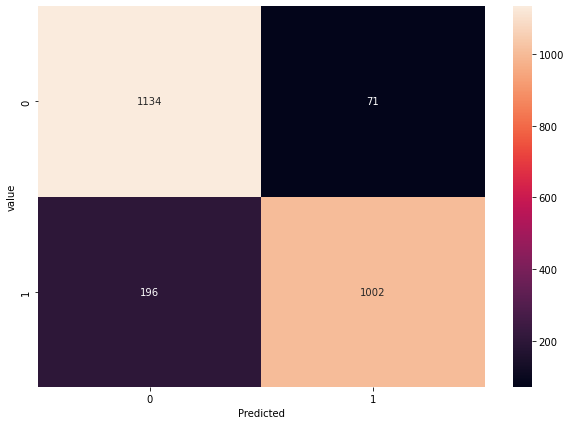

In [180]:
log_reg_model = LogisticRegression()
# Mean accuracy using cross validation
mean_accuracy = cross_val_score(log_reg_model, trained_tfidf, X_train['tweet_sentiment'], cv=10, scoring='accuracy')
print(f'\nAverage accuracy: {mean_accuracy.mean()}\n')
    
log_reg_model.fit(trained_tfidf, X_train['tweet_sentiment'])
    
plot_model(log_reg_model, y_test)

### SVM

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.4s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   3.3s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   3.5s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   2.5s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   2.5s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   2.6s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.5s
[CV] END ......................C=0.1, gamma=1, 

[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   3.5s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   3.5s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   3.5s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   3.5s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   7.7s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   7.8s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   6.4s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   4.2s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   4.3s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   3.6s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   3.9s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   4.1s
[CV] END ...................

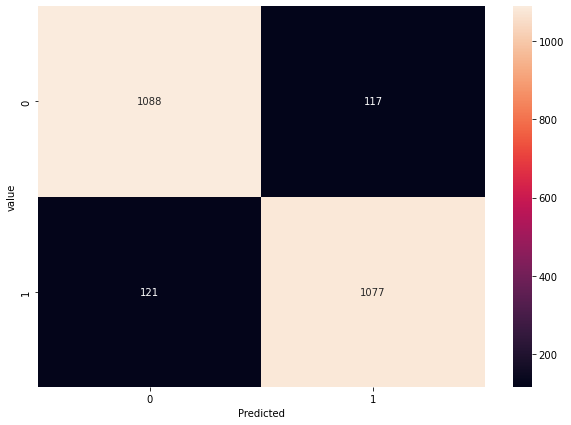

In [182]:
param_grid = {'C': [0.1,1, 10],
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'sigmoid','linear']}

svm_model = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
svm_model.fit(trained_tfidf, X_train['tweet_sentiment'])
print(svm_model.best_estimator_)

plot_model(svm_model, y_test)

# Test the model 

## 1- Test the model with Sentiment140 

In [189]:
def pipeline(model, test_data):
    """ This function takes a Pandas series data type as argument with two columns, 
        one column called tweet_sentiment and the other called text,
        It's hard coded just to test the model. 
    """
    # Preprocessing
    start = time.perf_counter()
    test_data['processed_tweets'] = test_data['text'].apply(preprocess_tweets)
    test_data['string_tweets'] = test_data['processed_tweets'].apply(convert_list_str)
    end = time.perf_counter()
    
    print(f'Processing time: {end - start}')
    # Display a sample of the processed tweets 
    #test_data.sample(10)
    
    # Transform processed tweet using tfidf vectorizer initiated and fitted above
    test_tfidf = tfidf.transform(test_data['string_tweets'])
    
    # Predict
    predictions = model.predict(test_tfidf)
    print(classification_report(test_data['tweet_sentiment'], predictions))
    cm = confusion_matrix(test_data['tweet_sentiment'], predictions, labels=[0, 1])
    print(cm)
    plt.figure(figsize= (10, 7))
    sn.heatmap(cm, annot=True, fmt='.0f')
    plt.xlabel('Predicted')
    plt.ylabel('value')
    plt.show()
    
    # Plot a pie 
    (unique, counts) = np.unique(predictions, return_counts=True)
    print(f'Unique: {unique}\t\tCounts: {counts}')
    
    neg_tweets_counts = counts[0]
    pos_tweets_counts = counts[1]
    labels = ["Negative", "Positive"]
    plt.pie(counts, labels=labels, shadow=True, autopct="%1.2f%%")

In [184]:
test_data = pd.read_csv('/home/verpen/Downloads/Datasets/Sentiment140.csv', encoding="ISO-8859-1")

In [185]:
# Rename columns
test_data = test_data.rename(columns={'0': 'tweet_sentiment', 
                   "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D": "text"})

# Keep tweet_sentiment and text drop the rest columns
test_data = test_data[['tweet_sentiment', 'text']]
test_data['tweet_sentiment'] = test_data['tweet_sentiment'].apply(lambda x: 1 if x == 4 else 0)

Processing time: 167.26584025299962
              precision    recall  f1-score   support

           0       0.67      0.72      0.69      4973
           1       0.70      0.65      0.68      5027

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000

[[3576 1397]
 [1743 3284]]


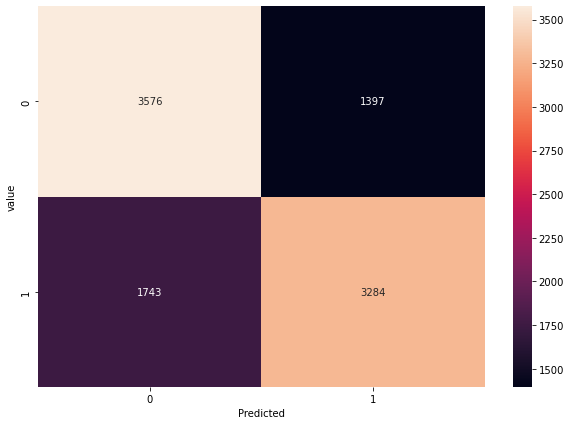

Unique: [0 1]		Counts: [5319 4681]


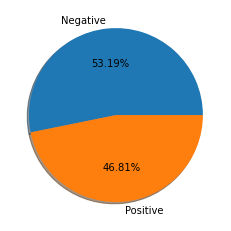

In [198]:
pipeline(log_model, test_data)